# Package

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Set up environment

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load data

In [4]:
from preprocessing.load_sup_dataset import load_train_test

In [5]:
# trainset, valset = raw_to_dict(data_mode = "small")
trainset, valset = load_train_test()

>> Loading the trainset
Total images are 93408


>> Loading the testset
Total images are 98904




In [6]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle = False, num_workers = 4)
len(trainloader), len(valloader)

(365, 387)

torch.Size([256, 3, 224, 224]) torch.Size([256])


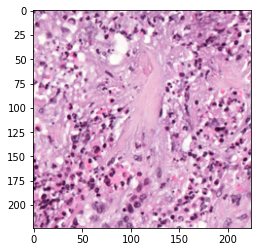

In [7]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# Baseline Model

In [8]:
from trainer.baseline_trainer import BaseLineTrainer

run_on = "CRC_DX"

In [9]:
baseline_trainer = BaseLineTrainer(trainloader, valloader, num_cycle = 5, valset = valset, netname = "ResNet18")
max_epochs = baseline_trainer.get_max_epochs()

In [10]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "baseline", run_on)
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX'

In [11]:
tb_logger = loggers.TensorBoardLogger('logs/', name = "baseline_" + run_on)
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


## Learning finder

In [12]:
lr_finder = trainer.lr_find(baseline_trainer)

INFO:lightning:
   | Name                                 | Type              | Params
-----------------------------------------------------------------------
0  | criterion                            | BCEWithLogitsLoss | 0     
1  | model                                | BaseLineModel     | 11 M  
2  | model.resnet18                       | ResNet            | 11 M  
3  | model.resnet18.conv1                 | Conv2d            | 9 K   
4  | model.resnet18.bn1                   | BatchNorm2d       | 128   
5  | model.resnet18.relu                  | ReLU              | 0     
6  | model.resnet18.maxpool               | MaxPool2d         | 0     
7  | model.resnet18.layer1                | Sequential        | 147 K 
8  | model.resnet18.layer1.0              | BasicBlock        | 73 K  
9  | model.resnet18.layer1.0.conv1        | Conv2d            | 36 K  
10 | model.resnet18.layer1.0.bn1          | BatchNorm2d       | 128   
11 | model.resnet18.layer1.0.relu         | ReLU            

INFO:lightning:LR finder stopped early due to diverging loss.


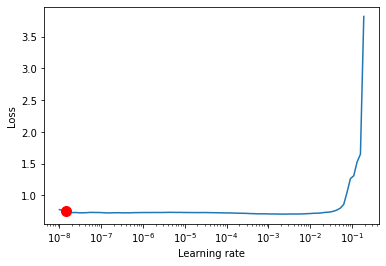

In [13]:
fig = lr_finder.plot(suggest=True)

In [14]:
baseline_trainer.base_lr = 1e-4
baseline_trainer.max_lr = 1e-2
baseline_trainer.configure_optimizers()

SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.002
    lr: 0.002
    max_lr: 0.01
    max_momentum: 0.95
    min_lr: 2e-07
    momentum: 0.95
    nesterov: False
    weight_decay: 0.0001
)

## Train model

In [15]:
trainer.fit(baseline_trainer)

INFO:lightning:
   | Name                                 | Type              | Params
-----------------------------------------------------------------------
0  | criterion                            | BCEWithLogitsLoss | 0     
1  | model                                | BaseLineModel     | 11 M  
2  | model.resnet18                       | ResNet            | 11 M  
3  | model.resnet18.conv1                 | Conv2d            | 9 K   
4  | model.resnet18.bn1                   | BatchNorm2d       | 128   
5  | model.resnet18.relu                  | ReLU              | 0     
6  | model.resnet18.maxpool               | MaxPool2d         | 0     
7  | model.resnet18.layer1                | Sequential        | 147 K 
8  | model.resnet18.layer1.0              | BasicBlock        | 73 K  
9  | model.resnet18.layer1.0.conv1        | Conv2d            | 36 K  
10 | model.resnet18.layer1.0.bn1          | BatchNorm2d       | 128   
11 | model.resnet18.layer1.0.relu         | ReLU            

INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=1.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=2.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=3.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=4.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=5.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=6.ckpt


INFO:lightning:
Epoch 00007: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=7.ckpt


INFO:lightning:
Epoch 00008: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=8.ckpt


INFO:lightning:
Epoch 00009: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=9.ckpt


INFO:lightning:
Epoch 00010: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=10.ckpt


INFO:lightning:
Epoch 00011: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=11.ckpt


INFO:lightning:
Epoch 00012: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=12.ckpt


INFO:lightning:
Epoch 00013: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=13.ckpt


INFO:lightning:
Epoch 00014: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=14.ckpt


INFO:lightning:
Epoch 00015: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=15.ckpt


INFO:lightning:
Epoch 00016: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=16.ckpt


INFO:lightning:
Epoch 00017: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=17.ckpt


INFO:lightning:
Epoch 00018: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=18.ckpt


INFO:lightning:
Epoch 00019: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/CRC_DX/epoch=19.ckpt


1

# Evaluate on test set

## Run evaluation for test set

In [ ]:
from evaluate.evaluator import Evaluator
from trainer.baseline_trainer import BaseLineTrainer

checkpoint_path = ["checkpoint/eval/baseline/epoch={}_v1.ckpt".format(x) for x in range(1, 20)]
evaluator = Evaluator(BaseLineTrainer, "Base line", checkpoint_path, trainloader, valloader, valset, "logs/eval/baseline/version1/")

In [ ]:
evaluator.run_validation()

## Run on noise set

In [ ]:
evaluator.run_test_set()

/home/kientiet/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0c208ba1f0>
Traceback (most recent call last):
  File "/home/kientiet/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/kientiet/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.8/multiprocessin

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0c208ba1f0>
Traceback (most recent call last):
  File "/home/kientiet/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/kientiet/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0c208ba1f0>
Traceback (most recent call last):
  File "/home/kientiet/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/kientiet/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  

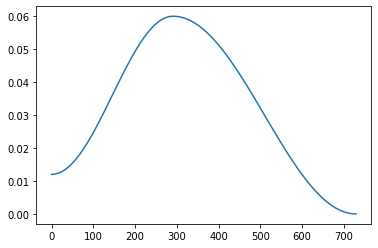

In [83]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
optimizer = optim.SGD(baseline_trainer.parameters(), lr = 6e-2)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 6e-2,
                                    epochs = 2,
                                    steps_per_epoch = len(trainloader),
                                      div_factor = 5,
                                      final_div_factor = 1e4
                                     )

lr_logs = []
for _ in range(2):
    for _ in tqdm(trainloader):
        lr_logs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

plt.plot(lr_logs)
plt.show()

In [84]:
lr_logs

[0.011999999999999997,
 0.012001398591213033,
 0.012005594201847367,
 0.012012586342907638,
 0.01202237419946494,
 0.012034956630751749,
 0.012050332170294914,
 0.012068499026086567,
 0.012089455080792955,
 0.012113197892001264,
 0.012139724692504218,
 0.012169032390622642,
 0.012201117570565793,
 0.012235976492829433,
 0.012273605094631705,
 0.01231399899038662,
 0.0123571534722152,
 0.012403063510494194,
 0.012451723754442257,
 0.012503128532743588,
 0.01255727185420892,
 0.012614147408473768,
 0.01267374856673395,
 0.012736068382518104,
 0.012801099592497325,
 0.01286883461733173,
 0.012939265562553752,
 0.013012384219488304,
 0.013088182066209472,
 0.013166650268533711,
 0.01324777968104951,
 0.013331560848183224,
 0.013417984005301198,
 0.013507039079847745,
 0.013598715692519137,
 0.013693003158473292,
 0.013789890488575096,
 0.013889366390677171,
 0.013991419270935973,
 0.014096037235163034,
 0.014203208090211222,
 0.014312919345395865,
 0.01442515821395051,
 0.01453991161451720